In [1]:
import os
import os.path as op
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats
from scipy.ndimage import measurements

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

import mne
from mne import EvokedArray
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm
from mne.decoding import CSP
from library import helpers, config

In [2]:

def load_scores_decod_tfr(sub_list_str, conditions, pwr_style = '', part_epo='stimon', signaltype='collapsed', 
                          scoring='roc_auc', reg='', picks_str='', load_chance_data=False):
    """Load decoding results from disc.
    
    Parameters
    ----------
    sub_list_str: list
        List of subject IDs
    conditions : list
        List of strings containing the classes of the classification. 
    pwr_style : str
        Should be 'induced' or empty. Default is ''.
    part_epo : str, optional
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon' (default is 'stimon').
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
                                                       (default is 'collapsed'.)
    scoring: 
        'roc_auc' or 'accuracy', not properly implemented yet in data, so see hack below.
    reg: str
        Regularization
    load_chance_data: bool
        Load scores from decoding runs with shuffeled labels.


    Returns
    -------
    results: ndarray 
        Array with decoding results (subjects x freqs x times)
    times: array, 1d
    freqs: array, 1d
    """
    
    #if scoring == 'accuracy':
    #    scoring = ''
    
    if len(sub_list_str) > 1:
         sub_folder = '-'.join(sub_list_str[0], sub_list_str[-1])
    else:
         sub_folder = sub_list_str[0]

    shuf_labs = 'labels_shuffled' if load_chance_data else ''
    contrast_str = '_vs_'.join(conditions)
    fpath = op.join(config.paths['06_decod_tfr, pwr_style, part_epo, signaltype, contrast_str, scoring, 
                    reg, picks_str, shuf_labs, sub_folder, 'scores')
    fname = op.join(fpath, 'scores_per_sub.npy')
    res = np.load(fname)
    times = np.load(fname[:-4] + '__times.npy')
    freqs = np.load(fname[:-4] + '__freqs.npy')
    return(res, times, freqs)


def get_freq_indices(freqs_of_interest, freqs_decoded):
    """Get indices of the relevant frequencies. 

    Parameters
    ----------
    freqs_of:_interest : list, tuple
        Specify freqs of interest as list, tuple or list of tuples:
        (8,13): include all freqs between 8 and 13
        [8, 13]: include all freq windows that entail either 8 or 13 (but not 9-11 for example)
    freqs_decoded : list
        nested list, specifying the freq windows that have been used for decoding. 
        Best to use the output of the decoding function or load it from disc.
        

    Returns
    -------
    list
        list of indices into freqs_decoded
    """
    
    indices = list()
    if not isinstance(freqs_of_interest, list):
        freqs_of_interest = [freqs_of_interest]
    for f_oi in freqs_of_interest:
        if isinstance(f_oi, tuple):
            f_oi = np.sort(f_oi)
            for idx, freq in enumerate(freqs_decoded):
                if((freq[0] == f_oi[0]) or (freq[-1] == f_oi[-1])):
                    indices.append(idx)
                elif ((freq[0] < f_oi[0] < freq[-1]) or (freq[0] < f_oi[-1] < freq[-1])): 
                    indices.append(idx)
                elif ((f_oi[0] < freq[0]) and (f_oi[-1] > freq[-1])):
                    indices.append(idx)
        else:
            for idx, freq in enumerate(freqs):
                if ((f_oi >= freq[0]) and (f_oi <= freq[1])):
                    indices.append(idx)
    indices = np.unique(indices)
    return(indices)


def plot_decod_image_tfr(scores, conditions, times, freqs, scoring='roc_auc', ax=None):
    """Plot a heatmap with decoding accuracy over time and frequency. 
    
    Parameters
    ----------
    scores : ndarray, 2d
        2d array with decoding results (freqs x timepoints)
    conditions : list
        List of strings containing the classes of the classification. 
    times: array, 1d
        Timepoints
    freqs: array, 1d
        Frequencies 
    ax: axis, optional
        Axis to plot into.

    Returns
    -------
    image
        AxisImage
    """
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    dx = np.diff(times)[0] / 2
    dy = 0 #np.diff(freqs)[0] / 2
    extent = [times.min()-dx, times.max()+dx,
              freqs.min()-dy, freqs.max()+dy]             
    image = ax.imshow(scores, origin='lower', cmap='Greens', aspect='auto', extent=extent)
    ax.set_yticks([f for frange in freqs for f in frange])
    ax.set_ylabel('frequency (Hz)')
    return(image)


def plot_score_ts(scores_df, plt_dict, color, sign_clusters=[], p_lvl=0.01, scoring='roc_auc', ax=None, n_boot=1000):
    """Plot the decoding scores as timeseries line plot.
    
    Parameters
    ----------
    scores_df : DataFrame 
        Data frame containing accuracies per time point in epoch. Long format. 
        Needed columns: 'time',
                        'score'
    plt_dict: dict
        Dict containing info relevant for plotting. 
        Entries needed: 't_stimon': relative time of stimulus onset
                        'xmin': minimal time to be plotted
                        'xmax': maximal time to be plotted
    color: str
        A single color string referred to by name, RGB or RGBA code,
        for instance ‘red’ or ‘#a98d19’. 
    sign_clusters: list
        start and end time of sign clusters
    p_lvl: float
        Sign. threshold used for cbp test
    ax: axis, optional
        Axis to plot into.
    n_boot: int
        Number of bootstrapping iterations for the CI.

    Returns
    -------
    image
        AxisImage
    
    """
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    image = sns.lineplot(x='time', 
                 y='score', 
                 hue = 'labels',  # 'original' or 'shuffled'
                 palette = config.colors,
                 #color = color,
                 data=scores_df,
                 ci = 95,
                 n_boot=n_boot,  
                 ax=ax)
    ytick_range = ax.get_ylim()
    ax.set(xlim=(plt_dict['xmin'], plt_dict['xmax']), ylim=ytick_range)
    if scoring == 'roc_auc':
        scoring_str = 'ROC AUC'
    else: 
        scoring_str = scoring
    ax.set_ylabel(scoring_str)
    ax.set_xlabel('Time (s)')
    ax.axvspan(plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, color='grey', alpha=0.3)
    ax.axvspan(plt_dict['t_stimon']+ 2.2, plt_dict['t_stimon'] + 2.5, color='grey', alpha=0.3)
    ax.vlines((plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, plt_dict['t_stimon']+2.2),
              ymin=ytick_range[0], ymax=ytick_range[1], 
              linestyles='dashed')
    p_lvl_str = 'p < .' + str(p_lvl).split('.')[-1]
    for sc in sign_clusters:
        xmin = sc[0]
        xmax = sc[-1]
        ax.hlines(ytick_range[0] + 0.05*np.ptp(ytick_range), xmin=xmin, xmax=xmax, color='purple', 
                 label=p_lvl_str)
    handles, labels = ax.get_legend_handles_labels()
    n_sgn_clu = None if len(sign_clusters) <= 1 else -(len(sign_clusters)-1)
    ax.legend(handles=handles[1:n_sgn_clu], labels=labels[1:n_sgn_clu])
    #plt.legend(title=None)

    return(image)

def get_evoked_info(part_epo='stimon', signaltype='collapsed', picks_str=None):
    fname = op.join(config.path_epos_sorted, part_epo, signaltype,
                    'VME_S01' + '-epo.fif')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    
    # pick channel selection:
    if (picks_str is not None) and (picks_str is not 'All'):
        roi_dict = mne.channels.make_1020_channel_selections(epos.info)
        picks = [epos.ch_names[idx] for idx in roi_dict[picks_str]]
        epos.pick_channels(picks, ordered=True)


    return(epos.info)
    

def run_cbp_test(data):
    # number of permutations to run
    n_permutations = 1000 
    # set initial threshold
    p_initial = 0.05
    # set family-wise p-value
    p_thresh = 0.05
    connectivity = None
    tail = 1.  # for one-sided test

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = mne.stats.permutation_cluster_1samp_test(
        data, threshold=threshold, n_jobs=config.n_jobs, verbose=False, tail=tail,
        step_down_p=0.0005, adjacency=connectivity,
        n_permutations=n_permutations, seed=42, out_type='mask')

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return(T_obs, clusters, cluster_p_values)

<>:207: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:207: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_145006/882655494.py:207: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (picks_str is not None) and (picks_str is not 'All'):


In [3]:
# plt.rcParams['figure.figsize'] = [5*3, 5*3]
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["legend.loc"] = 'upper left'
plt.rcParams['font.size'] = 18

conditions = ['LoadLow', 'LoadHigh']
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects) # + [7, 9, 10, 11, 12, 14])              
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

########WATCH OUT
# sub_list_str = ['VME_S01', 'VME_S02', 'VME_S03', 'VME_S04', 'VME_S05', 
#                 'VME_S06', 'VME_S08', 'VME_S09', 'VME_S10', 'VME_S13']

scoring = 'roc_auc' #'' #'accuracy' # 'balanced_accuracy' #   
reg = 'shrinkage0.4'#'' # 

scores_list = list()
for subID in sub_list_str:
    scores_sub, times, freqs = load_scores_decod_tfr([subID], conditions, pwr_style='', signaltype='collapsed', scoring=scoring, 
                                                    reg=reg, picks_str='')
    #print(scores_sub.shape)
    scores_list.append(scores_sub)
if len(scores_list[-1].shape) == 2: 
    scores_list = [arr[np.newaxis, :, :] for arr in scores_list]
elif len(scores_list[-1].shape) == 4: 
    scores_list = [arr.mean(axis=1) for arr in scores_list]

scores = np.concatenate(scores_list)

# load results from decoding with shuffled labels:
scores_list_chance = list()
for subID in sub_list_str:
    scores_sub_chance, times_chance, freqs_chance = load_scores_decod_tfr([subID], conditions, signaltype='collapsed', 
                                                                          scoring=scoring, reg=reg, picks_str='', 
                                                                          load_chance_data=True)
    scores_list_chance.append(scores_sub_chance)
if len(scores_list_chance[-1].shape) == 2: 
    scores_list_chance = [arr[np.newaxis, :, :] for arr in scores_list_chance]
elif len(scores_list_chance[-1].shape) == 4: 
    scores_list_chance = [arr.mean(axis=1) for arr in scores_list_chance]

print(scores_sub.shape)
    
if len(scores_list_chance[-1].shape) == 2: 
    scores_list_chance = [arr[np.newaxis, :, :] for arr in scores_list_chance]

scores_chance = np.concatenate(scores_list_chance)
assert (np.all(times == times_chance) and np.all(freqs == freqs_chance)), 'You try to load data with different times or freqs.'


# Specify freqs of interest as list, tuple or list of tuples:
# (8,13): include all freq between 8 and 13
# [8, 13]: include all freq windows that entail either 8 or 13 (but not 9-11 for example)
freqs_of_interest = (8,13)
# translate freqs_of_interest to index:
idx_freqs_of_intr = get_freq_indices(freqs_of_interest, freqs)


# Setup dict with infos for plotting:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': times[0],
      'xmax': times[-1]}
plt_dict['stimon'] = pp


fig, ax = plt.subplots(2,1, sharex=True, figsize=(13,16))

scores_avg = np.mean(scores, axis=0)
im = plot_decod_image_tfr(scores_avg, conditions, times, freqs, scoring, ax[0])

acc_df = pd.DataFrame(scores[:, idx_freqs_of_intr, :].mean(axis=1)) #average across freqs of interest
acc_df.columns = times
acc_df_long = acc_df.melt(var_name='time', value_name='score')  # put into long format
acc_df_long['decoding target'] = 'Load'
acc_df_long['labels'] = 'All'

acc_df_chance = pd.DataFrame(scores_chance[:, idx_freqs_of_intr, :].mean(axis=1)) #average across freqs of interest
acc_df_chance.columns = times
acc_df_long_chance = acc_df_chance.melt(var_name='time', value_name='score')  # put into long format
acc_df_long_chance['decoding target'] = 'Load'
acc_df_long_chance['labels'] = 'Chance'

acc_df_long = pd.concat([acc_df_long, acc_df_long_chance])

# run CBP test to find sign. clusters' times:
scores_ts = scores[:, idx_freqs_of_intr, :].mean(axis=1)
scores_ts_chance = scores_chance[:, idx_freqs_of_intr, :].mean(axis=1)
T_obs, clusters, p_values = run_cbp_test(scores_ts - scores_ts_chance) # 0.5) #
p_val_cbp = 0.01
idx_sign_clusters = np.argwhere(p_values<p_val_cbp)
sign_cluster_times = [times[clusters[idx[0]]][[0,-1]] for idx in idx_sign_clusters]

plot_score_ts(acc_df_long, plt_dict['stimon'], color='blue', scoring=scoring, sign_clusters=sign_cluster_times, p_lvl=p_val_cbp, ax=ax[1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.55, 0.01, 0.25])
if scoring == 'roc_auc':
    scoring_str = 'ROC AUC'
else:
    scoring_str = scoring
fig.colorbar(im, cax=cbar_ax, label=scoring_str)
txt_ax = fig.add_axes([0.85, 0.15, 0.01, 0.25])
txt_ax.set_axis_off()
freqs_formatted = '\n'.join([str(f) for f in freqs[idx_freqs_of_intr]])
txt_ax.text(0.5*(1), 0.5*(1), f'avg. over\nfrequency\nbands:\n{freqs_formatted}',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12, color='black',
        transform=txt_ax.transAxes)

fpath = op.join(config.path_plots, '10_tfr_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'AUC-Load_overall.svg')
fig.savefig(fname) 
    


AttributeError: module 'library.config' has no attribute 'path_decod_tfr'

### Plot patterns

In [11]:
# # %% Plot patterns:

# Load pattern data:

def load_patterns(sub_list_str, contrast_str, part_epo='stimon', signaltype='collapsed', scoring='roc_auc', reg='shrinkage0.4', picks_str=None, labels_shuffled=False):
    """Load the patterns from CSP based TFR decoding.
    
    Parameters
    ----------
    sub_list_str : list, str
        List of subject IDs to load patterns from. 
    part_epo : str
        Which part the epo was cropped to; defaults to "stimon"
    contrast_str : str
        Decoded contrast.
    signaltype : str
        "collapsed" or "difference" or "uncollapsed" (not yet implemented). Defaults to "collapsed";
    scoring: str
        Scoring metric used during decoding. "roc_auc" (default), accuracy", or "balanced_accuracy";
    reg: str, float
        Regularization method used; Ints are interpreted as fixed shrinkage values; defaults to "shrinkage0.4"
    labels_shuffled : bool
        Allows to load the data from the run with shuffled labels.
    picks_str: str
        Predefined selection, has to be either 'Left', 'Right', 'Midline' or 'All'; None (default) is thesame as 'All'


    Returns
    -------
    patterns: ndarray
        Array with the patterns (subs x csp_components x channels x freqs x times)
    times: array, 1d
    freqs: array, 1d
    
    """
    if not isinstance(sub_list_str, list):
        sub_list_str = [sub_list_str]
    if isinstance(reg, float):
        reg_str = 'shrinkage'+str(reg)
    else:
        reg_str = reg
    shuf_labs = 'labels_shuffled' if labels_shuffled else ''
    patterns_list = list()
    times = freqs = None
    for sub in sub_list_str:
        sub_folder = sub
        if (picks_str is not None) and (picks_str is not 'All'):
            picks_str_folder = picks_str
        else:
            picks_str_folder = ''
        fpath = op.join(config.path_decod_tfr, part_epo, signaltype, contrast_str, scoring, reg_str, picks_str_folder, shuf_labs, sub_folder, 'patterns')
        fname = op.join(fpath, 'patterns_per_sub.npy')
        patterns = np.load(fname)
        times_ = np.load(fname[:-4] + '__times' + '.npy')
        freqs_ = np.load(fname[:-4] + '__freqs' + '.npy')
        patterns_list.append(patterns)
        if times is None:
            times = times_
        else:
            assert (times==times_).all(), 'Times differ between subjects. That is problematic.'
        if freqs is None:
            freqs = freqs_
        else:
            assert (freqs == freqs_).all(), 'Freqs differ between subjects. That is problematic.'
    patterns = np.concatenate(patterns_list)
    return patterns, times, freqs

In [12]:
# load patterns:
sub_patterns_all, times, freqs = load_patterns(sub_list_str, 'LoadLow_vs_LoadHigh', picks_str=None)


In [13]:
freqs

array([[ 6.,  8.],
       [ 8., 10.],
       [10., 12.],
       [12., 14.],
       [14., 16.],
       [16., 18.],
       [18., 20.],
       [20., 22.],
       [22., 24.],
       [24., 26.]])

<ipython-input-2-02b126fa0ed8>:204: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-2-02b126fa0ed8>:204: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)


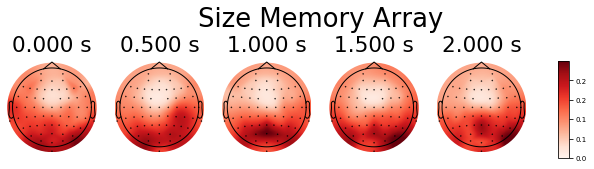

In [22]:
plt.rcParams['svg.fonttype'] = 'none'
# pick only first CSP component and average across freqs of interest:
#for i in np.arange(sub_patterns_all.shape[0]):
sub_patterns = sub_patterns_all[:,0,:,:,:] # .mean(axis=1) # 
sub_patterns = sub_patterns[:,:,2:5,:].mean(axis=-2)
sub_patterns_avg = sub_patterns.squeeze()
# normalize them by l2 norm to allow fair average across subjects:
sub_patterns_avg = sub_patterns_avg / np.linalg.norm(sub_patterns_avg, axis=1, ord=2, keepdims=True)
sub_patterns_avg = np.abs(sub_patterns_avg)
sub_patterns_avg = sub_patterns_avg.mean(axis=0) 

# normalize per timebin
sub_patterns_avg = sub_patterns_avg / np.linalg.norm(sub_patterns_avg, axis=0, ord=2, keepdims=True)
# get dummy epos.info file to get electrode locations
dummy_epos_info = get_evoked_info(picks_str='All')

# Build new pseudo Evoke obj:
sub_patterns_evo = EvokedArray(sub_patterns_avg, dummy_epos_info)
sub_patterns_evo.times = times
#sub_patterns_evo.plot_topomap()
fig = sub_patterns_evo.plot_topomap(times = times[1::2], #times, # [0.25, 0.4, 0.55, 0.85, 1.15, 1.25, 1.35, 1.45, 1.5, 1.6, 1.8, 2.0], 
                              scalings=1, units='', 
                                title=config.labels['Load'], cmap = 'Reds', vmin = 0, contours=0, ch_type='eeg')
fpath = op.join(config.path_plots, '10_tfr_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'AUC-Load_overall_patterns.svg')
fig.savefig(fname) 

In [23]:
sub_patterns_evo

<Evoked | '' (average, N=1), [-0.25, 2.25] sec, 26 ch, ~89 kB>

In [6]:
conditions = ['EccS', 'EccM']

sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

scores_list = list()
for subID in sub_list_str:
    scores_sub, times, freqs = load_scores_decod_tfr([subID], conditions, signaltype='collapsed')
    scores_list.append(scores_sub)

scores = np.concatenate(scores_list)

# load results from decoding with shuffled labels:
scores_list_chance = list()
for subID in sub_list_str:
    scores_sub_chance, times_chance, freqs_chance = load_scores_decod_tfr([subID], conditions, signaltype='collapsed', 
                                                                          load_chance_data=True)
    scores_list_chance.append(scores_sub_chance)

scores_chance = np.concatenate(scores_list_chance)
assert (np.all(times == times_chance) and np.all(freqs == freqs_chance)), 'You try to load data with different times or freqs.'


# Specify freqs of interest as list, tuple or list of tuples:
# (8,13): include all freq between 8 and 13
# [8, 13]: include all freq windows that entail either 8 or 13 (but not 9-11 for example)
freqs_of_interest = (10,13)
# translate freqs_of_interest to index:
idx_freqs_of_intr = get_freq_indices(freqs_of_interest, freqs)


# Setup dict with infos for plotting:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': times[0],
      'xmax': times[-1]}
plt_dict['stimon'] = pp


fig, ax = plt.subplots(2,1, sharex=True)

scores_avg = np.mean(scores, axis=0)
im = plot_decod_image_tfr(scores_avg, conditions, times, freqs, ax[0])

acc_df = pd.DataFrame(scores[:, idx_freqs_of_intr, :].mean(axis=1)) #average across freqs of interest
acc_df.columns = times
acc_df_long = acc_df.melt(var_name='time', value_name='score')  # put into long format
acc_df_long['decoding target'] = 'Load'

# run CBP test to find sign. clusters' times:
scores_ts = scores[:, idx_freqs_of_intr, :].mean(axis=1)
T_obs, clusters, p_values = run_cbp_test(scores_ts - 0.5)
idx_sign_clusters = np.argwhere(p_values<0.01)
sign_cluster_times = [times[clusters[idx[0]]][[0,-1]] for idx in idx_sign_clusters]

plot_score_ts(acc_df_long, plt_dict['stimon'], color='black', sign_clusters=sign_cluster_times, ax=ax[1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.55, 0.01, 0.25])
fig.colorbar(im, cax=cbar_ax, label='accuracy')
txt_ax = fig.add_axes([0.88, 0.15, 0.01, 0.25])
txt_ax.set_axis_off()
freqs_formatted = '\n'.join([str(f) for f in freqs[idx_freqs_of_intr]])
txt_ax.text(0.5*(1), 0.5*(1), f'avg. over\nfrequency\nbands:\n{freqs_formatted}',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12, color='black',
        transform=txt_ax.transAxes)

FileNotFoundError: [Errno 2] No such file or directory: '/draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/10_tfr_decoding/stimon/collapsed/EccS_vs_EccM/roc_auc/VME_S01/scores/scores_per_sub.npy'

In [99]:

sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

part_epo='stimon'
signaltype='collapsed'
shuf_labs = 'labels_shuffled'

for i, ecc in enumerate(['S', 'M', 'L']):
    #conditions = ['EccS', 'Ecc' + ecc]
    conditions = ['LoadLowEcc'+ecc, 'LoadHighEcc'+ecc]
    contrast_str = '_vs_'.join(conditions) 
    for v2w_str in ['patterns', 'scores']:
        fpath = op.join(config.path_decod_tfr, part_epo, signaltype, contrast_str, shuf_labs, '', v2w_str)
        fname = op.join(fpath, v2w_str+'_per_sub.npy')
        vs_to_write = np.load(fname)
        timesp = np.load(fname[:-4] + '__times.npy')
        freqsp = np.load(fname[:-4] + '__freqs.npy')
        for subID, v_to_write in zip(sub_list_str, vs_to_write):
            sub_folder = subID
            fpath = op.join(config.path_decod_tfr, part_epo, signaltype, contrast_str, shuf_labs, sub_folder, v2w_str)
            helpers.chkmk_dir(fpath)
            fname = op.join(fpath, v2w_str+'_per_sub.npy')
            res = np.save(fname, v_to_write)
            times = np.save(fname[:-4] + '__times.npy', timesp)
            freqs = np.save(fname[:-4] + '__freqs.npy', freqsp)

In [98]:
fname

'/draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/10_tfr_decoding/stimon/collapsed/LoadLowEccL_vs_LoadHighEccL/VME_S27/scores/scores_per_sub.npy'

In [52]:
from shutil import copyfile
for i, ecc in enumerate(['S', 'M', 'L']):
    #conditions = ['EccM', 'Ecc' + ecc]
    conditions = ['LoadLowEcc'+ecc, 'LoadHighEcc'+ecc]
    contrast_str = '_vs_'.join(conditions) 
    shuf_labs = 'labels_shuffled'
    fpath = op.join(config.path_decod_tfr, part_epo, signaltype, contrast_str, shuf_labs, '')
    fname = op.join(fpath, 'info.json')
    for subID in sub_list_str:
        fpath_targ = op.join(fpath, subID)
        fname_targ = op.join(fpath_targ, 'info.json')
        copyfile(fname, fname_targ)

In [6]:
config.colors['All'] = 'blue'


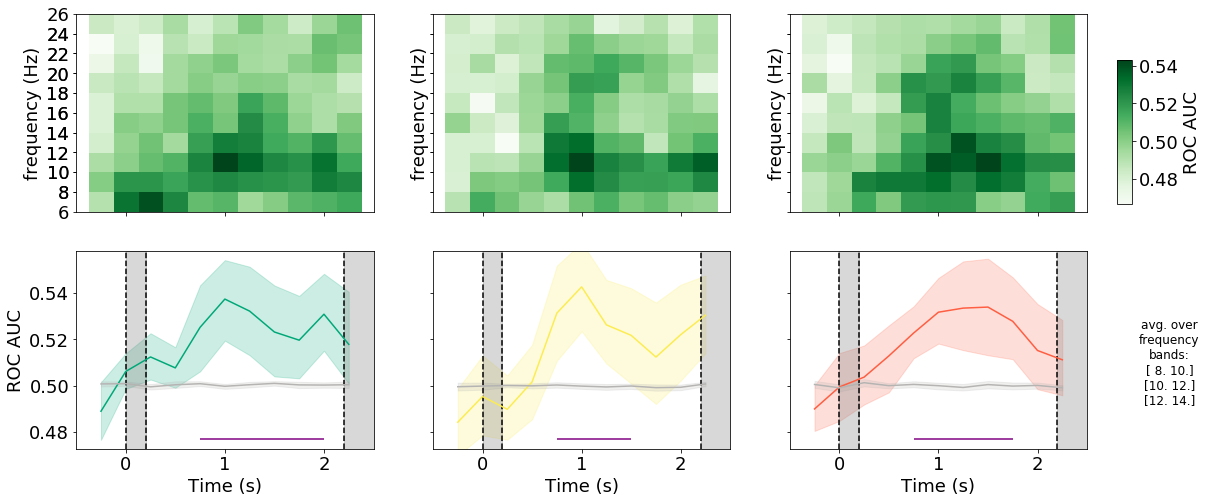

In [21]:
            
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects) 

sub_list_str = ['VME_S%02d' % sub for sub in sub_list]
        
scoring = 'roc_auc' #'accuracy' #'roc_auc', #'balanced_accuracy' #  
reg = 'shrinkage0.4' #'' # 

freqs_of_interest = (8, 14)
# translate freqs_of_interest to index:
#idx_freqs_of_intr = get_freq_indices(freqs_of_interest, freqs)


plt.rcParams['svg.fonttype'] = 'none'


fig, axx = plt.subplots(2,3, sharex=True, sharey='row')

for i, ecc in enumerate(['S', 'M', 'L']):
    conditions = ['LoadLowEcc' + ecc, 'LoadHighEcc' + ecc]

    scores_list = list()
    for subID in sub_list_str:
        scores_sub, times, freqs = load_scores_decod_tfr([subID], conditions, signaltype='collapsed', reg=reg, scoring=scoring)
#         scores_list.append(scores_sub.mean(axis=1))

#     if len(scores_list[-1].shape) == 2: 
#         scores_list = [arr[np.newaxis, :, :] for arr in scores_list]

    
        scores_list.append(scores_sub)
    if len(scores_list[-1].shape) == 2: 
        scores_list = [arr[np.newaxis, :, :] for arr in scores_list]
    elif len(scores_list[-1].shape) == 4: 
        scores_list = [arr.mean(axis=1) for arr in scores_list]

    scores = np.concatenate(scores_list)
        
    # load results from decoding with shuffled labels:
    scores_list_chance = list()
    for subID in sub_list_str:
        scores_sub_chance, times_chance, freqs_chance = load_scores_decod_tfr([subID], conditions, signaltype='collapsed', 
                                                                              scoring='roc_auc', reg='', load_chance_data=True)
        scores_list_chance.append(scores_sub_chance)
    if len(scores_list_chance[-1].shape) == 2: 
        scores_list_chance = [arr[np.newaxis, :, :] for arr in scores_list_chance]
    elif len(scores_list_chance[-1].shape) == 4: 
        scores_list_chance = [arr.mean(axis=1) for arr in scores_list_chance]

    scores_chance = np.concatenate(scores_list_chance)
    assert (np.all(times == times_chance) and np.all(freqs == freqs_chance)), 'You try to load data with different times or freqs.'

    plt_dict = defaultdict(dict)
    pp = {'t_stimon':  0,
          'xmin': times[0]-0.25,
          'xmax': times[-1]+0.25}
    plt_dict['stimon'] = pp

    # translate freqs_of_interest to index:
    idx_freqs_of_intr = get_freq_indices(freqs_of_interest, freqs)

    
    # Plot heatmap (freqs x times):
    scores_avg = np.mean(scores, axis=0) # average across subjects
    im = plot_decod_image_tfr(scores_avg, conditions, times, freqs, scoring, axx[0,i])
    
    # Plot time series (averaged across frequencies of interest)
    if not isinstance(idx_freqs_of_intr, list): 
        idx_freqs_oi = [idx_freqs_of_intr]
    acc_df = pd.DataFrame(scores[:, idx_freqs_of_intr, :].mean(axis=1)) #average across freqs of interest
    acc_df.columns = times
    acc_df_long = acc_df.melt(var_name='time', value_name='score')  # put into long format
    acc_df_long['decoding target'] = 'Load'
    acc_df_long['labels'] = 'Ecc'+ecc  # 'Load: 2 vs. 4'

    acc_df_chance = pd.DataFrame(scores_chance[:, idx_freqs_of_intr, :].mean(axis=1)) #average across freqs of interest
    acc_df_chance.columns = times
    acc_df_long_chance = acc_df_chance.melt(var_name='time', value_name='score')  # put into long format
    acc_df_long_chance['decoding target'] = 'Load'
    acc_df_long_chance['labels'] = 'Chance'  # 'chance'

    acc_df_long = pd.concat([acc_df_long, acc_df_long_chance])
    
    # run CBP test to find sign. clusters' times:
    scores_ts = scores[:, idx_freqs_of_intr, :].mean(axis=1)
    scores_ts_chance = scores_chance[:, idx_freqs_of_intr, :].mean(axis=1)
    
    T_obs, clusters, p_values = run_cbp_test(scores_ts - scores_ts_chance) #  #) #0.49) #  
    idx_sign_clusters = np.argwhere(p_values<0.01)
    sign_cluster_times = [times[clusters[idx[0]]][[0,-1]] for idx in idx_sign_clusters]

    plot_score_ts(acc_df_long, plt_dict['stimon'], color=config.colors['Ecc'+ecc], sign_clusters=sign_cluster_times, 
                  scoring=scoring, ax=axx[1,i], n_boot=1000)
    axx[1,i].get_legend().remove()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.55, 0.01, 0.25])
if scoring == 'roc_auc':
    scoring_str = 'ROC AUC'
else:
    scoring_str = scoring
fig.colorbar(im, cax=cbar_ax, label=scoring_str)
txt_ax = fig.add_axes([0.85, 0.15, 0.01, 0.25])
txt_ax.set_axis_off()
freqs_formatted = '\n'.join([str(f) for f in freqs[idx_freqs_of_intr]])
txt_ax.text(0.5*(1), 0.5*(1), f'avg. over\nfrequency\nbands:\n{freqs_formatted}',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12, color='black',
        transform=txt_ax.transAxes)

fpath = op.join(config.path_plots, '10_tfr_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'AUC-Load_perEcc.svg')
fig.savefig(fname) 

plt.rcParams['figure.figsize'] = [13*1.6, 5*1.6]
plt.rcParams["legend.loc"] = 'upper left'

In [86]:
fpath = op.join(config.path_decod_tfr, '')

In [19]:
config.path_plots

'/draco/ptmp/fklotzsche/Experiments/vMemEcc/Plots'

In [133]:
# calc repeated anova:
res = list()
for i, ecc in enumerate(['S', 'M', 'L']):
    conditions = ['LoadLowEcc' + ecc, 'LoadHighEcc' + ecc]

    scores_list = list()
    for subID in sub_list_str:
        scores_sub, times, freqs = load_scores_decod_tfr([subID], conditions, signaltype='collapsed', 
                                                        scoring='roc_auc', reg='shrinkage0.4')
        scores_list.append(scores_sub)
    if len(scores_list[-1].shape) == 2: 
        scores_list = [arr[np.newaxis, :, :] for arr in scores_list]
    elif len(scores_list[-1].shape) == 4: 
        scores_list = [arr.mean(axis=1) for arr in scores_list]

    scores = np.concatenate(scores_list)
 
    res.append(scores[:, idx_freqs_of_intr, :].mean(axis=1))
data = np.asarray(res).swapaxes(1,0)
fs, ps = mne.stats.f_mway_rm(data, factor_levels=[3])

In [134]:
ps

array([0.88325134, 0.55940301, 0.08920254, 0.47055573, 0.88471453,
       0.45836666, 0.90970696, 0.62383296, 0.69915379, 0.24835578,
       0.02497544])

In [141]:
dd = dict()
for i, ecc in enumerate(['S', 'M', 'L']):
    conditions = ['LoadLowEcc' + ecc, 'LoadHighEcc' + ecc]

    scores_list = list()
    for subID in sub_list_str:
        scores_sub, times, freqs = load_scores_decod_tfr([subID], conditions, signaltype='collapsed')
        scores_list.append(scores_sub)

    if len(scores_list[0].shape) == 2: 
        scores_list = [arr[np.newaxis, :, :] for arr in scores_list]
    scores = np.concatenate(scores_list)
    
    # load results from decoding with shuffled labels:
    scores_list_chance = list()
    for subID in sub_list_str:
        scores_sub_chance, times_chance, freqs_chance = load_scores_decod_tfr([subID], conditions, signaltype='collapsed', 
                                                                              load_chance_data=True)
        scores_list_chance.append(scores_sub_chance)

    if len(scores_list_chance[0].shape) == 2: 
        scores_list_chance = [arr[np.newaxis, :, :] for arr in scores_list_chance]
    scores_chance = np.concatenate(scores_list_chance)
    dd[ecc] = scores_chance

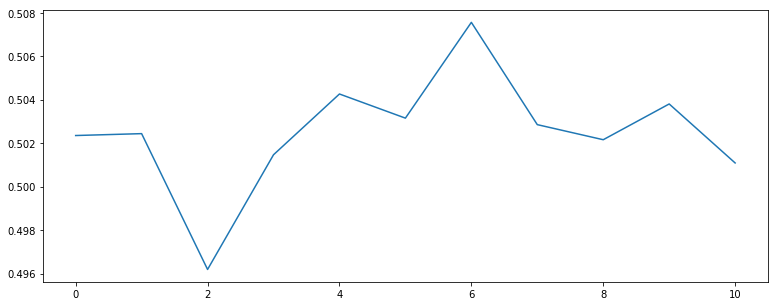

In [130]:
ha = [dd[ddd][:,idx_freqs_of_intr,:].mean(axis=1).mean(axis=0) for ddd in dd]
he = np.asarray(ha)
plt.plot(he.mean(axis=0))

In [27]:
ha = [1, 2,3,4,5]

In [31]:
ha[2:]

[3, 4, 5]

In [34]:
np.r_[[1,1,1,], [2,2]]

array([1, 1, 1, 2, 2])

In [47]:


def get_epos(subID, part_epo, signaltype, condition, event_dict):
    """Load a set of specified epochs.
    
     Parameters
    ----------
    subID : str
        Subject identifier (eg, 'VME_S05')
    part_epo : str
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon'
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
    condition: str
        Experimental condition. Combination of 'Ecc' and 'Load' (eg, 'LoadLow' or 'LoadLowEccS')
    event_dict: dict
        Dictionnary explaining the event codes. Normally this can be grabbed from config.event_dict

    Returns
    -------
    mne.Epochs
        Array of selected epochs.
    """
    
    if signaltype == 'uncollapsed':
        fname = op.join(config.path_rejepo, subID + '-' + part_epo +
                        '-postica-rejepo' + '-epo.fif')
    elif signaltype in ['collapsed']:
        fname = op.join(config.path_epos_sorted, part_epo, signaltype,
                        subID + '-epo.fif')
    else:
        raise ValueError(f'Invalid value for "signaltype": {signaltype}')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    uppers = [letter.isupper() for letter in condition]
    if (np.sum(uppers) > 2):
        cond_1 = condition[:np.where(uppers)[0][2]]
        cond_2 = condition[np.where(uppers)[0][2]:]
        selection = epos[event_dict[cond_1]][event_dict[cond_2]]
    else:
        selection = epos[event_dict[condition]]
    return(selection)


def get_sensordata(subID, part_epo, signaltype, conditions, event_dict):
    """Load a set of specified epochs for classification.
    
     Parameters
    ----------
    subID : str
        Subject identifier (eg, 'VME_S05')
    part_epo : str
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon'
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
    conditions: list
        List of experimental conditions. Combination of 'Ecc' and 'Load' (eg, 'LoadLow' or 'LoadLowEccS')
    event_dict: dict
        Dictionnary explaining the event codes. Normally this can be grabbed from config.event_dict

    Returns
    -------
    X_epos: Epochs
        Array of selected epochs, sorted by class (starting with class '0').
    y: list
        Sorted list of labels.
    times_n: array, 1d
        Times of the samples within the single epoch.
    """
    
    epos_dict = defaultdict(dict)
    for cond in conditions:
        epos_dict[cond] = get_epos(subID,
                                   part_epo=part_epo,
                                   signaltype=signaltype,
                                   condition=cond,
                                   event_dict=event_dict)

    times = epos_dict[conditions[0]][0].copy().times

    # Setup data:
    X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
    n_ = {cond: len(epos_dict[cond]) for cond in conditions}

    times_n = times

    y = np.r_[np.zeros(n_[conditions[0]]),
              np.concatenate([(np.ones(n_[conditions[i]]) * i)
                              for i in np.arange(1, len(conditions))])]

    return X_epos, y, times_n



In [204]:
xx, yy, tt = get_sensordata('VME_S03', part_epo='stimon', signaltype='collapsed', conditions=['LoadLowEccS', 'LoadHighEccS'], event_dict=config.event_dict)

<ipython-input-47-8f67d153c6c3>:35: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-47-8f67d153c6c3>:35: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-47-8f67d153c6c3>:35: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-47-8f67d153c6c3>:35: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-47-8f67d153c6c3>:86: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])


In [208]:
len(xx[config.event_dict['LoadLow']][config.event_dict['EccS']])

109

In [209]:
yy[:110]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1.])

In [210]:
xx[109:].event_id

{'Stimulus/S155': 155,
 'Stimulus/S157': 157,
 'Stimulus/S154': 154,
 'Stimulus/S156': 156}

In [211]:
X_epos_filter = xx.copy().filter(8, 10, n_jobs=-2, fir_design='firwin')

In [212]:
X = X_epos_filter.copy().crop(0, 0.5)

In [214]:
X[109:].event_id

{'Stimulus/S155': 155,
 'Stimulus/S157': 157,
 'Stimulus/S154': 154,
 'Stimulus/S156': 156}

In [215]:
Xddd = X.get_data()
Xddd[117]

array([[ 2.48626044e-06,  2.30940545e-06,  2.10649389e-06, ...,
        -4.34472577e-07, -5.88601995e-07, -7.36161994e-07],
       [ 1.16699074e-06,  1.11800302e-06,  1.05414346e-06, ...,
        -2.86567130e-08, -1.83513089e-07, -3.36693702e-07],
       [ 2.61256241e-06,  2.65406473e-06,  2.65872898e-06, ...,
         1.70941631e-07,  1.11324448e-07,  5.08777169e-08],
       ...,
       [ 2.40988808e-06,  2.24003704e-06,  2.04313967e-06, ...,
        -4.51055519e-07, -6.40996903e-07, -8.23662525e-07],
       [ 1.63546192e-06,  1.44502275e-06,  1.23992426e-06, ...,
        -5.62511513e-07, -7.52985977e-07, -9.33361362e-07],
       [ 4.23203369e-06,  3.65679579e-06,  3.02777297e-06, ...,
         5.74772462e-07,  5.73793702e-07,  5.61429176e-07]])

In [193]:
ddd = X[116].get_data()

In [220]:
X[110].get_data() == Xddd[110,:,:]

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])

In [84]:
yy[:116]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [85]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=354)

In [86]:
cv

StratifiedKFold(n_splits=5, random_state=354, shuffle=True)

In [87]:
cv.get_n_splits()

5

In [188]:
ha = cv.split(X_epos_filter, yy)

In [189]:
for train_index, test_index in ha:
    #print("TRAIN:", train_index, "TEST:", test_index)
    print(np.vstack([X_epos_filter[test_index].events[:,2], yy[test_index]]))
    
    #X_train, X_test = X_epos_filter[train_index], X_epos_filter[test_index]
    #y_train, y_test = y[train_index], y[test_index]

[[153. 151. 151. 151. 151. 153. 151. 151. 153. 151. 153. 152. 150. 150.
  150. 152. 150. 152. 150. 150. 152. 150. 150. 152. 157. 157. 157. 155.
  157. 157. 157. 155. 157. 155. 155. 154. 154. 156. 154. 156. 154. 156.
  156. 154. 154. 156. 154. 154.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.]]
[[153. 151. 153. 151. 151. 153. 153. 151. 153. 153. 153. 151. 153. 151.
  151. 152. 150. 152. 152. 150. 152. 150. 150. 155. 155. 157. 157. 157.
  155. 157. 155. 155. 155. 157. 155. 155. 157. 157. 154. 154. 156. 154.
  156. 156. 154. 156.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.]]
[[151. 151. 153. 151. 

In [94]:
ha[0]

TypeError: 'generator' object is not subscriptable